# CNN para detección de objetos en ASL

David René Langarica Hernández | A01708936

En el presente notebook se implementa un modelo de detección de objetos para la lengua de señas americana (ASL). El modelo es capaz de detectar las letras del alfabeto ASL a partir de imágenes. Se utiliza una red neuronal convolucional (CNN) para la clasificación de las imágenes.

## Importar librerias e indicar directorios

En primer lugar, se importan las librerias necesarias y se declaran variables que van a representar los directorios en dónde se encuentran nuestras imagenes.

In [60]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [61]:
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## Constantes

Declaramos las constantes `IMAGE_SIZE` y `BATCH_SIZE` que nos ayudaran a definir el tamaño de las imagenes y el tamaño del batch respectivamente.

In [62]:
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32

## Preparación de datos

En esta sección se crean los generadores de datos para las imágenes. La función `ImageDataGenerator` permite preprocesar las imágenes. 

En este caso, se aplica una normalización (rescale) dividiendo los valores de los píxeles (originalmente entre 0-255) por 255, para que queden en un rango de 0 a 1. Se crean tres generadores separados para los conjuntos de entrenamiento, validación y prueba.

In [63]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

## Generadores

En esta sección, creamos flujos de datos a partir de los directorios de imágenes utilizando el método `flow_from_directory`. Este método permite cargar las imágenes directamente desde carpetas organizadas, donde cada subcarpeta representa una clase diferente. 

In [64]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode ='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode ='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode ='categorical',
)

Found 44429 images belonging to 7 classes.
Found 12691 images belonging to 7 classes.
Found 6342 images belonging to 7 classes.


## Array de clases

El array de clases es un arreglo que contiene las etiquetas de las clases que queremos predecir. En este caso, las clases son las primeras 7 letras del abecedario en ASL. Este array se utilizará para mapear las etiquetas numéricas a las letras correspondientes. El array se puede crear a partir de los nombres de las carpetas en el directorio de entrenamiento.

In [65]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

## Ejemplos de clases

A continuación se muestran algunos ejemplos de las clases que se utilizarán en el modelo. Estas imágenes son representativas de las letras A, B, C, D, E, F y G en ASL.

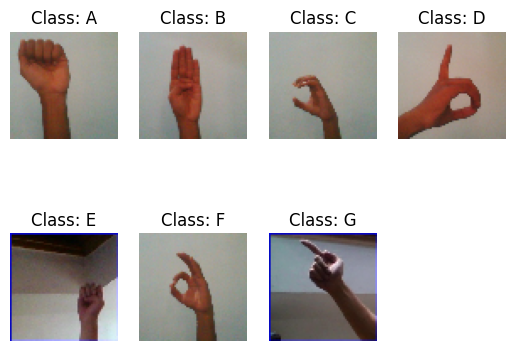

In [66]:
class_examples = {}
num_classes = len(class_names) 

while len(class_examples) < num_classes:
    images, labels = next(train_generator)
    for i in range(len(images)):
        class_idx = np.argmax(labels[i])
        if class_idx not in class_examples and class_idx < num_classes:
            class_examples[class_idx] = images[i]
    
    if len(class_examples) == num_classes:
        break


plt.figure()

for i, class_idx in enumerate(sorted(class_examples.keys())):
    plt.subplot(2, 4, i + 1)
    plt.imshow(class_examples[class_idx])
    plt.title(f'Class: {class_names[class_idx]}')
    plt.axis('off')

plt.show()

## Arquitectura del modelo

A continuación se define la arquitectura del modelo de Convolutional Neural Network (CNN) que se utilizará para clasificar las imágenes de ASL. El modelo consta de tres bloques convolucionales seguidos de capas densas. Cada bloque convolucional incluye una capa Conv2D seguida de MaxPooling2D para reducir la dimensionalidad. Se incluye una capa de Dropout para evitar el sobreajuste.

In [67]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])
model.summary()

c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,567,175 (17.42 MB)

 Trainable params: 4,567,175 (17.42 MB)

 Non-trainable params: 0 (0.00 B)

## Compilación del modelo

En esta sección se compila el modelo utilizando el optimizador Adam, la función de pérdida categorical_crossentropy (por la naturaleza multi-clase del problema) y la métrica de precisión para evaluar el rendimiento del modelo durante el entrenamiento.

In [68]:
model.compile(optimizer="adam", loss = "categorical_crossentropy", metrics=['accuracy'])

## Entrenamiento del modelo

En esta sección se entrena el modelo utilizando los generadores de datos creados anteriormente. Se implementa la técnica de Early Stopping que detiene el entrenamiento cuando el modelo deja de mejorar en la métrica de validación, evitando así el sobreajuste. El parámetro 'patience' indica cuántas épocas debe esperar antes de detener el entrenamiento si no hay mejoras.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 514/1389 ━━━━━━━━━━━━━━━━━━━━ 2:03 142ms/step - accuracy: 0.5638 - loss: 1.0700

## Evaluación del modelo

Evaluamos el rendimiento del modelo utilizando el generador de datos de prueba. La función `evaluate` devuelve la pérdida y la precisión del modelo en el conjunto de datos de prueba. Estos valores nos indican qué tan bien generaliza el modelo a datos no vistos durante el entrenamiento.

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)

print('\nTest accuracy:', test_acc)

397/397 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.9995 - loss: 0.0010

Test accuracy: 0.9996848106384277


## Visualización del entrenamiento

Posteriormente, visualizamos el progreso del entrenamiento del modelo a través de gráficas de precisión y pérdida. Estas gráficas muestran cómo evoluciona el rendimiento del modelo tanto en el conjunto de entrenamiento como en el de validación a lo largo de las épocas de entrenamiento. Es útil para detectar problemas como el sobreajuste (cuando la precisión de entrenamiento es significativamente mayor que la de validación).

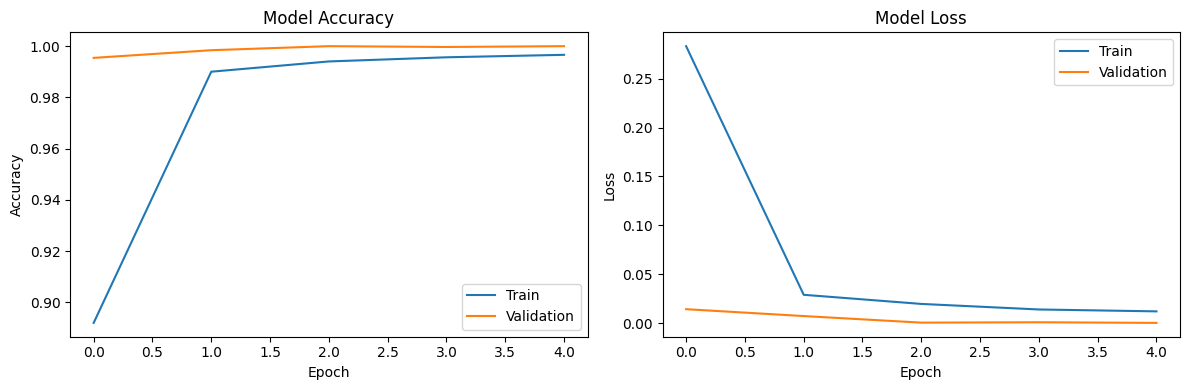

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

## Matriz de confusión

En esta celda se genera una matriz de confusión para visualizar el rendimiento del modelo. La matriz de confusión muestra cuántas predicciones fueron correctas para cada clase y qué clases fueron confundidas entre sí. Para esto, se utiliza un generador de prueba sin mezclar (shuffle=False) para asegurar que las etiquetas verdaderas y las predicciones estén alineadas correctamente.

Found 12691 images belonging to 7 classes.


c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step


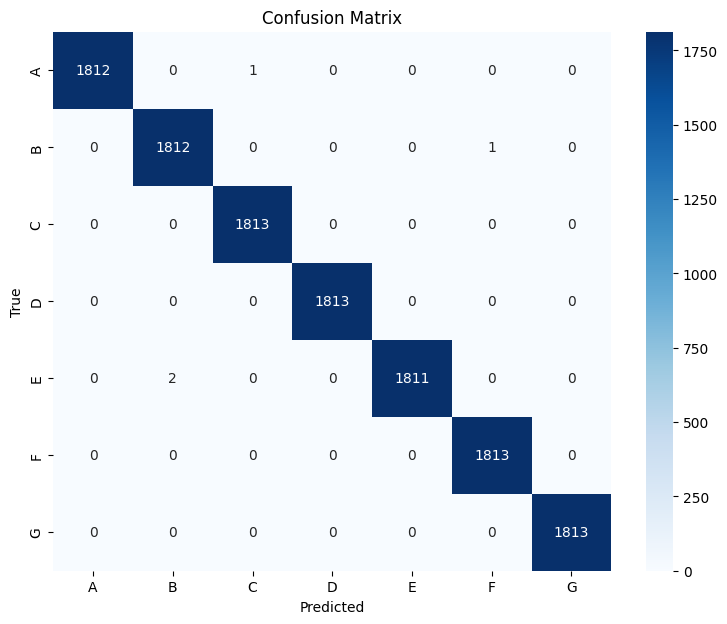

              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1813
           B       1.00      1.00      1.00      1813
           C       1.00      1.00      1.00      1813
           D       1.00      1.00      1.00      1813
           E       1.00      1.00      1.00      1813
           F       1.00      1.00      1.00      1813
           G       1.00      1.00      1.00      1813

    accuracy                           1.00     12691
   macro avg       1.00      1.00      1.00     12691
weighted avg       1.00      1.00      1.00     12691



In [ ]:
test_generator_unshuffled = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

y_pred = model.predict(test_generator_unshuffled)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator_unshuffled.classes[:len(y_pred_classes)]

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=class_names))

## Predicciones

En esta sección, se realizan predicciones sobre un conjunto de imágenes de prueba. Se cargan las imágenes y se procesan para que tengan el mismo tamaño que las imágenes de entrenamiento. Luego, se utilizan las funciones `predict` y `argmax` para obtener las predicciones del modelo.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


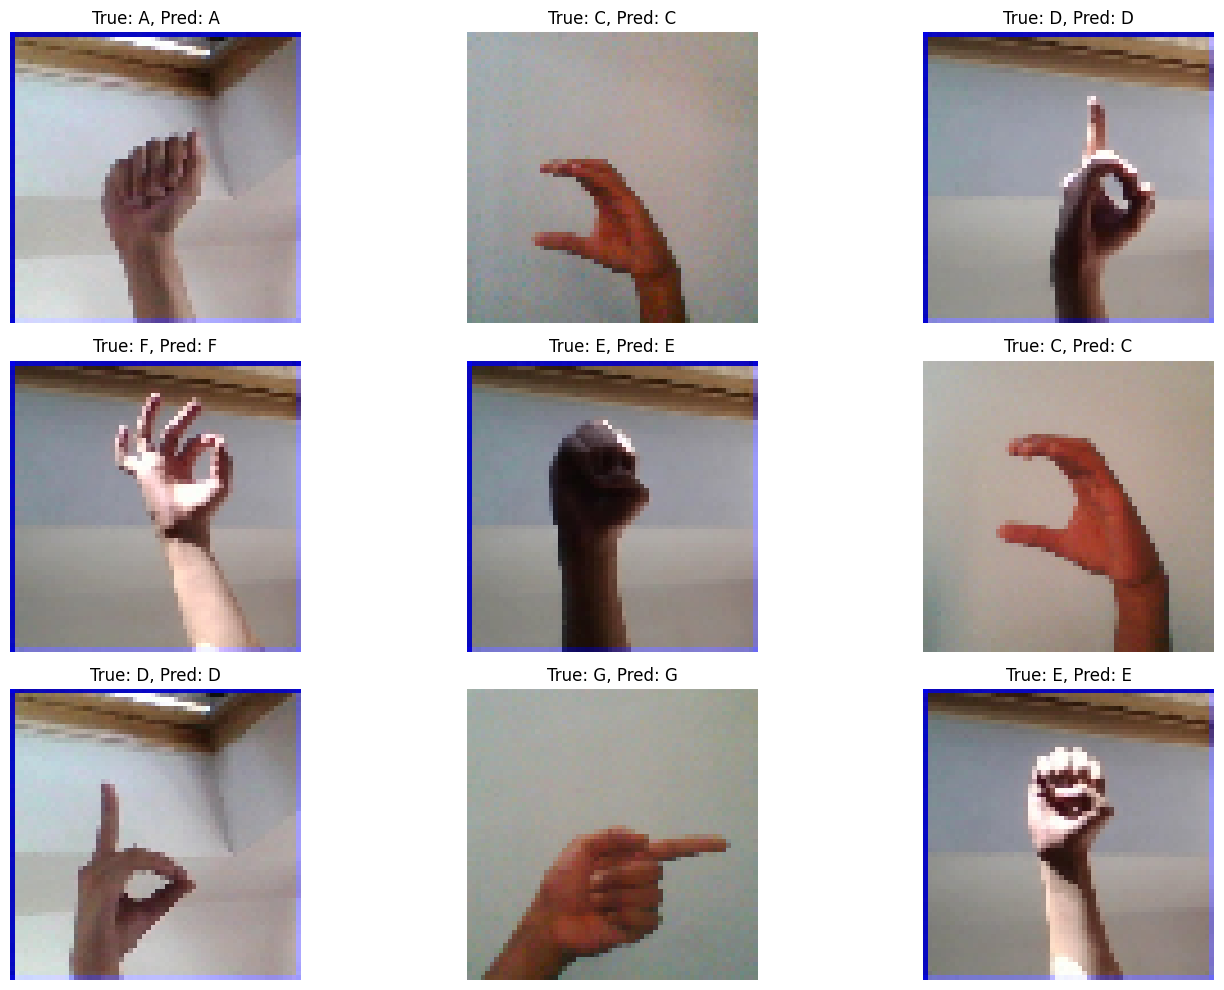

In [ ]:
plt.figure(figsize=(15, 10))
batch_x, batch_y = next(test_generator)

for i in range(min(9, len(batch_x))):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch_x[i])
    
    true_class = np.argmax(batch_y[i])
    pred_class = np.argmax(model.predict(np.expand_dims(batch_x[i], axis=0)))
    
    plt.title(f"True: {class_names[true_class]}, Pred: {class_names[pred_class]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Guardar el modelo

Finalmente, se guarda el modelo entrenado en un archivo KERAS. Esto permite cargar el modelo más tarde sin necesidad de volver a entrenarlo. El archivo guardado contiene la arquitectura del modelo y la configuraciones.

In [ ]:
model.save('asl_model.keras')
print("Modelo guardado como 'asl_model.keras")

Model saved to 'asl_model.keras'
